# Customer Segmentation with Unsupervised Learning using FLO's Dataset

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Settings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Task 1: 
Data Preparation.

Step 1: Read the flo_data_20K.csv data.

In [2]:
df_ = pd.read_csv('flo_data_20k.csv')

In [3]:
df = df_.copy()

Step 2: Choose the variables you will use when segmenting customers.

Note: You can create new variables such as Tenure (Customer's age), Recency (How many days ago he/she last shopped).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [5]:
# Converting Date Columns to DateTime Format
date_cols = df.columns[df.columns.str.contains('date')]
date_cols

Index(['first_order_date', 'last_order_date', 'last_order_date_online',
       'last_order_date_offline'],
      dtype='object')

In [6]:
df[date_cols] = df[date_cols].apply(pd.to_datetime)

In [7]:
df[['first_order_date', 'last_order_date', 
    'last_order_date_online', 'last_order_date_offline']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_date         19945 non-null  datetime64[ns]
 1   last_order_date          19945 non-null  datetime64[ns]
 2   last_order_date_online   19945 non-null  datetime64[ns]
 3   last_order_date_offline  19945 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 623.4 KB


In [8]:
# Max. last order date in the dataset
df['last_order_date'].max()

Timestamp('2021-05-30 00:00:00')

In [9]:
# Analysis Date: 2 days after maximum last order date (2021, 6, 1) 
analysis_date = dt.datetime(2021, 6, 1)
analysis_date

datetime.datetime(2021, 6, 1, 0, 0)

In [10]:
df['recency'] = (analysis_date - df['last_order_date']).astype('timedelta64[D]')
df['tenure'] = (df['last_order_date']-df['first_order_date']).astype('timedelta64[D]')

# Task 2: 
Customer Segmentation with K-Means.

Step 1: Standardize the variables.

In [11]:
df_segment = df[['order_num_total_ever_online', 'order_num_total_ever_offline', 
                 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 
                 'recency', 'tenure']]
df_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   order_num_total_ever_online        19945 non-null  float64
 1   order_num_total_ever_offline       19945 non-null  float64
 2   customer_value_total_ever_offline  19945 non-null  float64
 3   customer_value_total_ever_online   19945 non-null  float64
 4   recency                            19945 non-null  float64
 5   tenure                             19945 non-null  float64
dtypes: float64(6)
memory usage: 935.0 KB


- Plotting Before Log Transformation

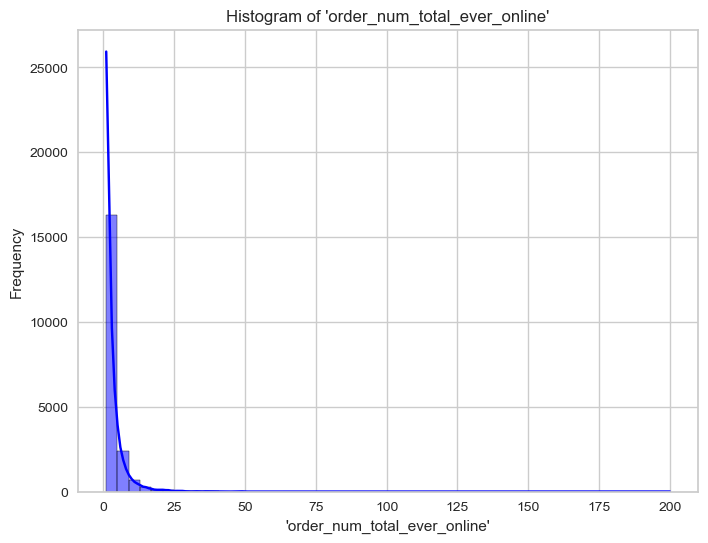

Skewness before log transformation for 'order_num_total_ever_online': 10.488


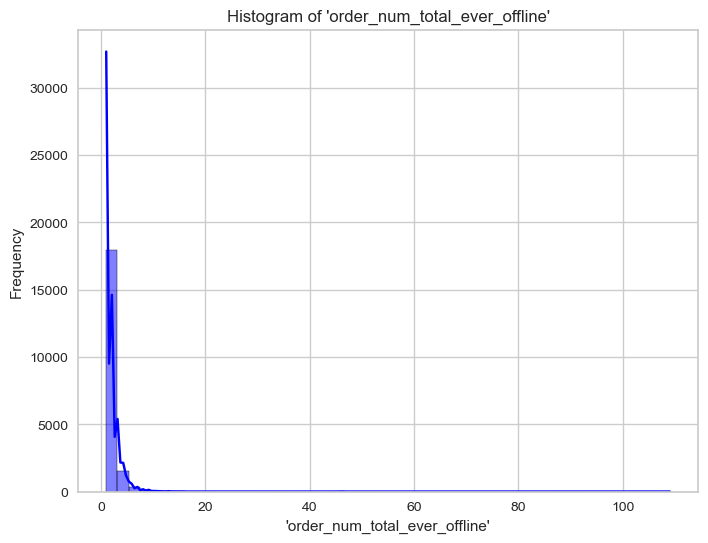

Skewness before log transformation for 'order_num_total_ever_offline': 20.330


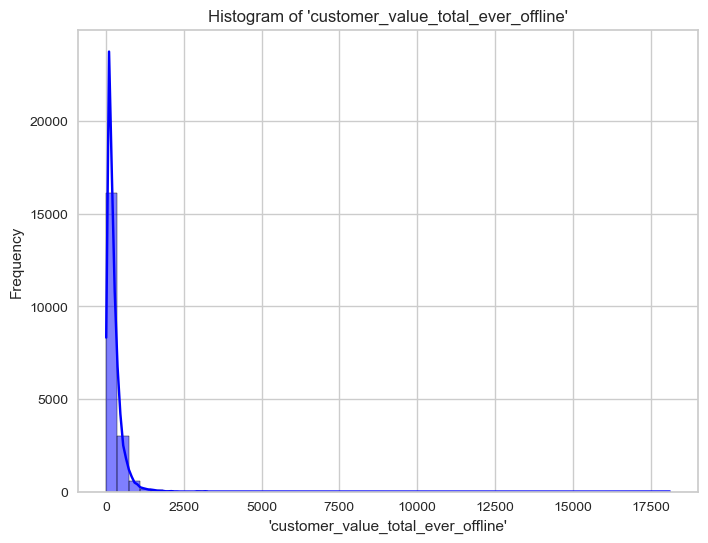

Skewness before log transformation for 'customer_value_total_ever_offline': 16.301


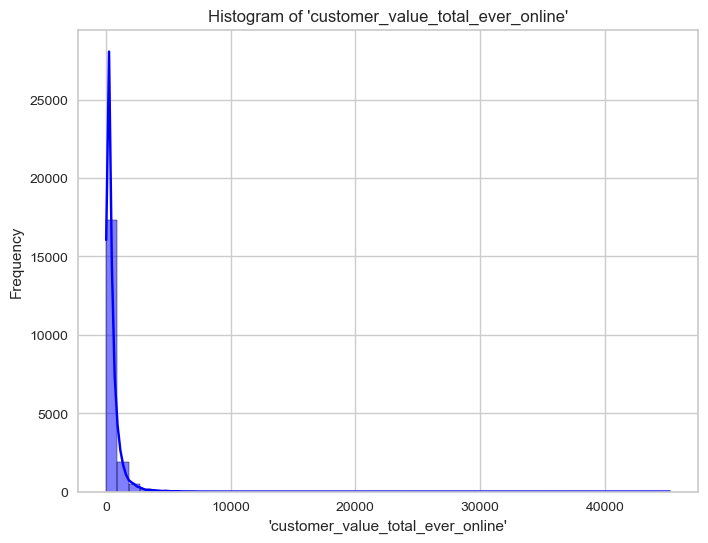

Skewness before log transformation for 'customer_value_total_ever_online': 20.086


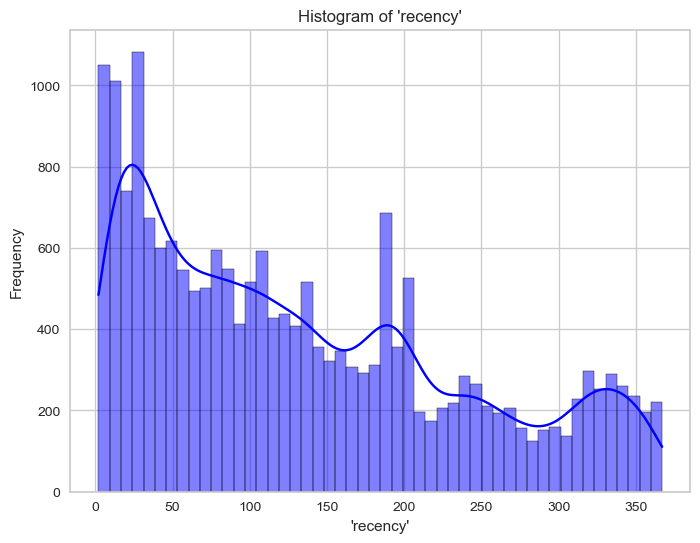

Skewness before log transformation for 'recency': 0.617


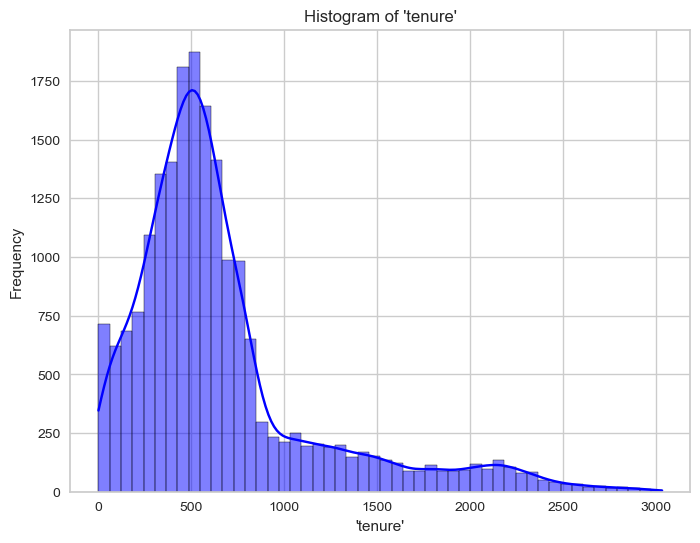

Skewness before log transformation for 'tenure': 1.756


In [12]:
# Store skewness results
skewness_results = []

# Visualize and print skewness for each variable in df_segment
for variable in df_segment:
    # Plotting without log transformation
    plt.figure(figsize=(8, 6))
    sns.histplot(df[variable], bins=50, kde=True, color='blue')
    plt.title(f"Histogram of '{variable}'")
    plt.xlabel(f"'{variable}'")
    plt.ylabel('Frequency')
    plt.show()

    # Skewness before log transformation
    skewness_before = df[variable].skew()
    print(f"Skewness before log transformation for '{variable}': {skewness_before:.3f}")

    # Append skewness result to the lists
    skewness_results.append(skewness_before)

- Plotting After Log Transformation

In [13]:
# Log transformation to ensure normal distribution
df_segment = np.log1p(df_segment)
df_segment.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.609,0.693,4.949,6.685,4.564,4.787
1,2.996,1.099,5.081,7.525,4.663,7.293
2,1.386,1.099,5.252,5.982,5.231,5.905
3,0.693,0.693,3.713,4.419,4.913,2.485
4,0.693,0.693,3.932,5.081,4.466,6.368


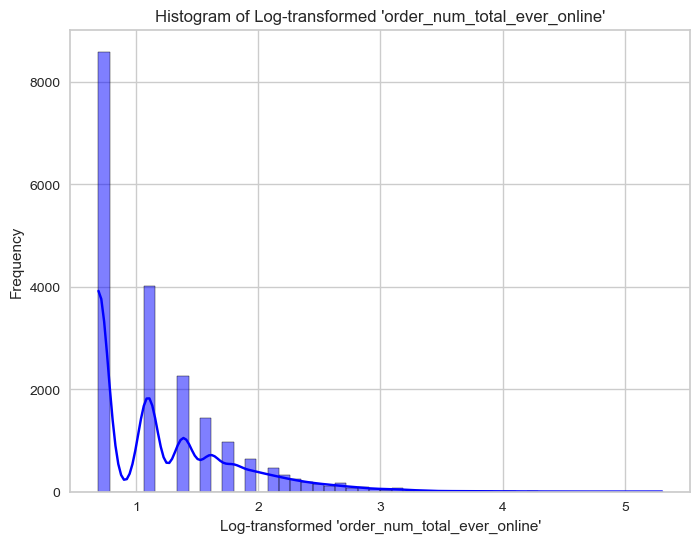

Skewness after log transformation for 'order_num_total_ever_online': 1.272


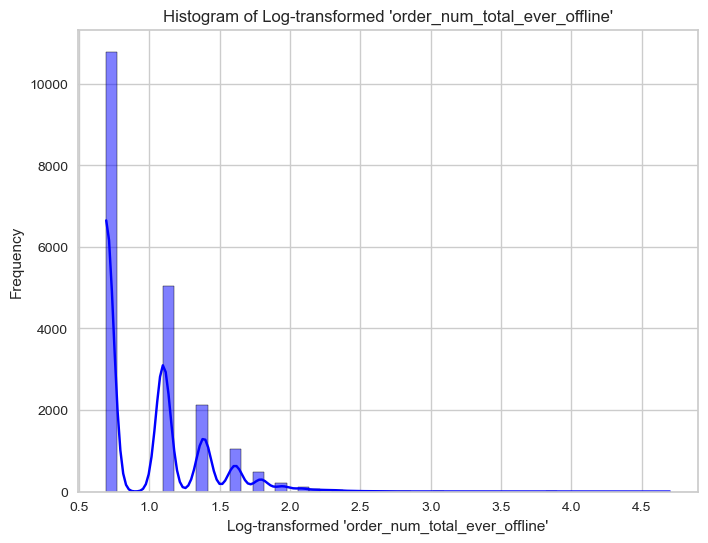

Skewness after log transformation for 'order_num_total_ever_offline': 1.518


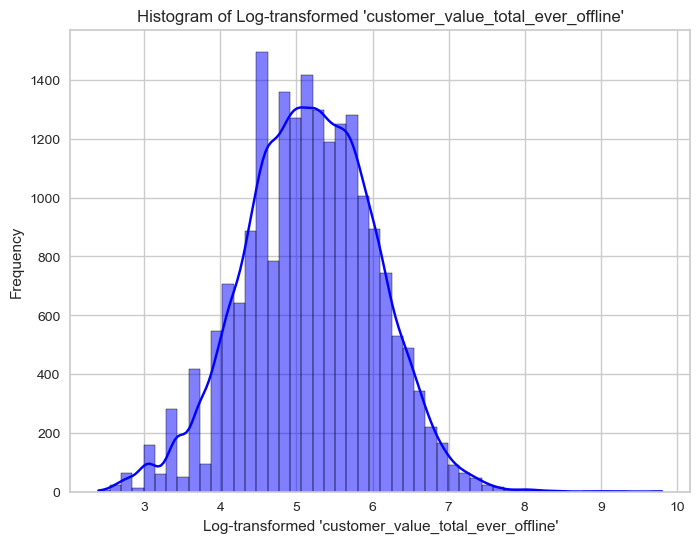

Skewness after log transformation for 'customer_value_total_ever_offline': -0.047


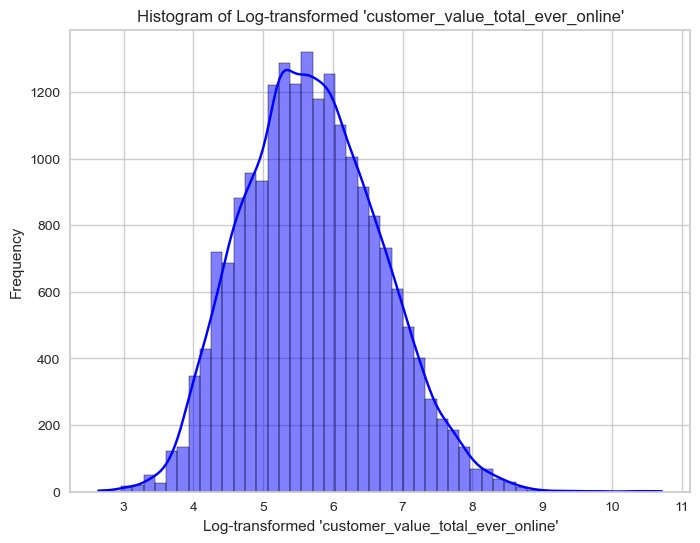

Skewness after log transformation for 'customer_value_total_ever_online': 0.234


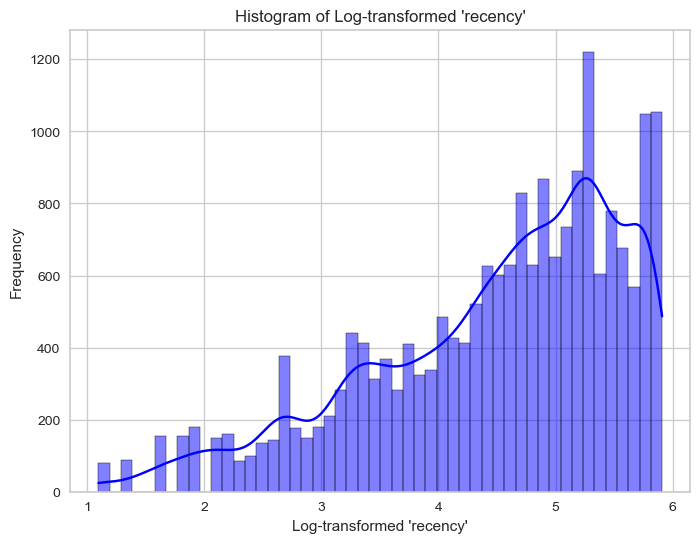

Skewness after log transformation for 'recency': -0.842


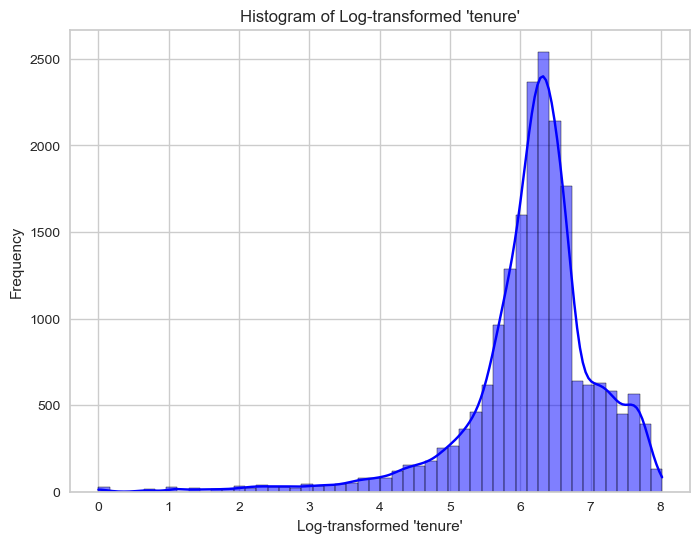

Skewness after log transformation for 'tenure': -1.832


In [14]:
# Store log-transformed skewness results
log_transformed_skewness = []

# Visualize and print skewness for each variable in df_segment
for variable in df_segment.columns:
    # Plotting with log transformation
    plt.figure(figsize=(8, 6))
    sns.histplot(df_segment[variable], bins=50, kde=True, color='blue')
    plt.title(f"Histogram of Log-transformed '{variable}'")
    plt.xlabel(f"Log-transformed '{variable}'")
    plt.ylabel('Frequency')
    plt.show()

    # Skewness after log transformation
    skewness_after = df_segment[variable].skew()
    print(f"Skewness after log transformation for '{variable}': {skewness_after:.3f}")

    # Append log-transformed skewness result to the list
    log_transformed_skewness.append(skewness_after)

- Skewness results before and after Log Transformation

In [15]:
# Column names
columns = ['', 'order_num_total_ever_online', 'order_num_total_ever_offline', 
           'customer_value_total_ever_offline', 'customer_value_total_ever_online', 
           'recency', 'tenure']

df_skewness = pd.DataFrame({
    'Variable': columns[1:],
    'Before Log Transformation': skewness_results,
    'After Log Transformation': log_transformed_skewness
    })

print('\nSkewness results before and after Log Transformation\n')
print(df_skewness.to_markdown(index=False, floatfmt='.3f'))


Skewness results before and after Log Transformation

| Variable                          |   Before Log Transformation |   After Log Transformation |
|:----------------------------------|----------------------------:|---------------------------:|
| order_num_total_ever_online       |                      10.488 |                      1.272 |
| order_num_total_ever_offline      |                      20.330 |                      1.518 |
| customer_value_total_ever_offline |                      16.301 |                     -0.047 |
| customer_value_total_ever_online  |                      20.086 |                      0.234 |
| recency                           |                       0.617 |                     -0.842 |
| tenure                            |                       1.756 |                     -1.832 |


- Standardizing

In [16]:
mm_scaler = MinMaxScaler()
df_scaling = mm_scaler.fit_transform(df_segment)
df_segment = pd.DataFrame(df_scaling, columns=df_segment.columns)
df_segment.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.199,0.000,0.344,0.501,0.721,0.597
1,0.499,0.101,0.362,0.605,0.741,0.910
2,0.150,0.101,0.385,0.414,0.859,0.737
3,0.000,0.000,0.178,0.220,0.793,0.310
4,0.000,0.000,0.207,0.302,0.700,0.794


Step 2: Determine the optimum number of clusters.

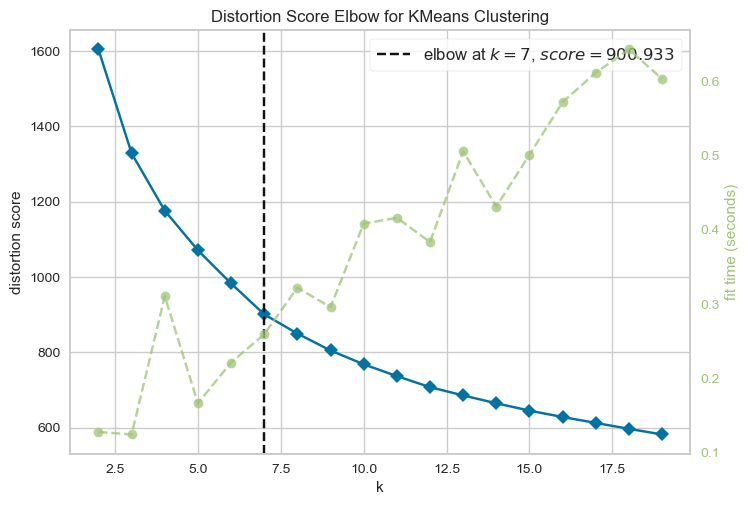

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
kmeans = KMeans(random_state=42)
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df_segment)
elbow.show()

In [18]:
elbow.elbow_value_

7

Step 3: Create your model and segment your customers.

- K-Means Clustering

In [19]:
k_means = KMeans(n_clusters=elbow.elbow_value_, random_state= 42).fit(df_segment)

In [20]:
kmeans_segments = k_means.labels_
kmeans_segments

array([6, 6, 6, ..., 4, 1, 2])

In [21]:
df_kmeans = df[['master_id', 'order_num_total_ever_online', 'order_num_total_ever_offline', 
                 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 
                 'recency', 'tenure']].copy() # To avoid the 'SettingWithCopyWarning' .copy() method is used

df_kmeans['kmeans_segment_no'] = kmeans_segments
df_kmeans.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,kmeans_segment_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.000,1.000,139.990,799.380,95.000,119.000,6
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.000,2.000,159.970,1853.580,105.000,1469.000,6
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.000,2.000,189.970,395.350,186.000,366.000,6
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.000,1.000,39.990,81.980,135.000,11.000,0
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.000,1.000,49.990,159.990,86.000,582.000,3


In [22]:
# Adding 1 to clusters that are starting from 0
df_kmeans['kmeans_segment_no'] = df_kmeans['kmeans_segment_no'] + 1
df_kmeans.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,kmeans_segment_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.000,1.000,139.990,799.380,95.000,119.000,7
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.000,2.000,159.970,1853.580,105.000,1469.000,7
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.000,2.000,189.970,395.350,186.000,366.000,7
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.000,1.000,39.990,81.980,135.000,11.000,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.000,1.000,49.990,159.990,86.000,582.000,4


Step 4: Examine each segment statistically.

In [23]:
df_kmeans.groupby('kmeans_segment_no').agg({'order_num_total_ever_online': ['count', 'mean', 'min', 'max'],
                                 'order_num_total_ever_offline': ['count', 'mean', 'min', 'max'],
                                 'customer_value_total_ever_offline': ['count', 'mean', 'min', 'max'],
                                 'customer_value_total_ever_online': ['count', 'mean', 'min', 'max'],
                                 'recency': ['count', 'mean', 'min', 'max'],
                                 'tenure': ['count', 'mean', 'min', 'max']
                                 })

order_num_total_ever_online                      \
                                        count  mean   min     max   
kmeans_segment_no                                                   
1                                         827 1.404 1.000   8.000   
2                                        3274 1.827 1.000  13.000   
3                                        5440 1.420 1.000   5.000   
4                                        3341 1.608 1.000   6.000   
5                                        1837 2.191 1.000  12.000   
6                                        1976 8.614 2.000 200.000   
7                                        3250 6.387 1.000  55.000   

                  order_num_total_ever_offline                      \
                                         count  mean   min     max   
kmeans_segment_no                                                    
1                                          827 1.128 1.000   6.000   
2                                         3274 3.763 1.000 109.000   
3                                         5440 1.279 1.000   5.000   
4                                         3341 1.479 1.000   6.000   
5                                         1837 2.099 1.000  14.000   
6                                         1976 2.093 1.000  36.000   
7                                         3250 1.548 1.000  16.000   

                  customer_value_total_ever_offline          ...  \
                                              count    mean  ...   
kmeans_segment_no                                            ...   
1                                               827 192.397  ...   
2                                              3274 550.526  ...   
3                                              5440 144.786  ...   
4                                              3341 186.023  ...   
5                                              1837 293.742  ...   
6                                              1976 278.685  ...   
7                                              3250 185.702  ...   

                  customer_value_total_ever_online           recency          \
                                               min       max   count    mean   
kmeans_segment_no                                                              
1                                           19.990  3476.810     827 139.556   
2                                           14.990  2587.200    3274 153.488   
3                                           12.990  1519.170    5440 225.858   
4                                           14.000  1307.330    3341  50.360   
5                                           23.990  3444.080    1837   9.998   
6                                          265.970 45220.130    1976  32.566   
7                                          180.960 12038.180    3250 179.756   

                                 tenure                          
                     min     max  count    mean    min      max  
kmeans_segment_no                                                
1                  4.000 367.000    827  37.154  0.000  132.000  
2                 22.000 366.000   3274 729.197 20.000 2911.000  
3                 88.000 367.000   5440 489.920 52.000 2820.000  
4                 15.000 109.000   3341 604.338 43.000 2828.000  
5                  2.000  27.000   1837 663.670  2.000 2962.000  
6                  2.000 109.000   1976 966.522 18.000 3034.000  
7                 55.000 367.000   3250 944.254 26.000 2964.000  

[7 rows x 24 columns]

# Task 3: 
Customer segmentation with Hierarchical Clustering.

Step 1: Determine the optimum number of clusters using the dataframe you standardized in Task 2.

- Hierarchical Clustering 
  - Agglomerative Clustering 

In [24]:
hc_complete = linkage(df_segment, method='complete')

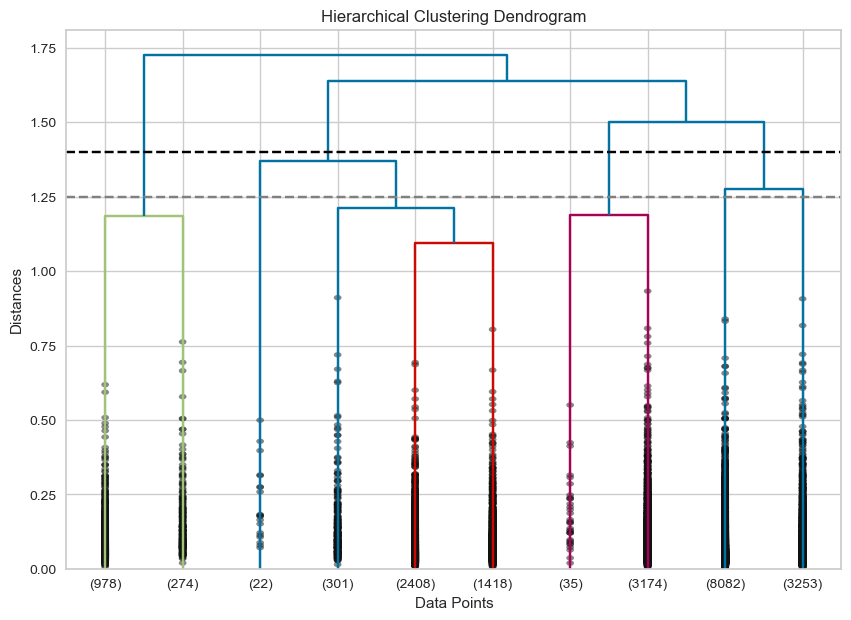

In [25]:
# Hierarchical Clustering Dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distances')
dendrogram(hc_complete,
           truncate_mode='lastp',
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=1.40, color='black', linestyle='--')
plt.axhline(y=1.25, color='grey', linestyle='--')
plt.show()

Step 2: Create your model and segment your customers.

In [26]:
hc_agg = AgglomerativeClustering(n_clusters=5, linkage='complete')

In [27]:
hc_segments = hc_agg.fit_predict(df_segment)
hc_segments

array([1, 3, 2, ..., 0, 2, 0], dtype=int64)

In [28]:
df_hc = df[['master_id', 'order_num_total_ever_online', 'order_num_total_ever_offline', 
                 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 
                 'recency', 'tenure']].copy() # To avoid the 'SettingWithCopyWarning' .copy() method is used

df_hc['hc_segment_no'] = hc_segments
df_hc.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,hc_segment_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.000,1.000,139.990,799.380,95.000,119.000,1
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.000,2.000,159.970,1853.580,105.000,1469.000,3
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.000,2.000,189.970,395.350,186.000,366.000,2
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.000,1.000,39.990,81.980,135.000,11.000,0
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.000,1.000,49.990,159.990,86.000,582.000,0


In [29]:
# Adding 1 to clusters that are starting from 0
df_hc['hc_segment_no'] = df_hc['hc_segment_no'] + 1
df_hc.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,hc_segment_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.000,1.000,139.990,799.380,95.000,119.000,2
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.000,2.000,159.970,1853.580,105.000,1469.000,4
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.000,2.000,189.970,395.350,186.000,366.000,3
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.000,1.000,39.990,81.980,135.000,11.000,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.000,1.000,49.990,159.990,86.000,582.000,1


Step 3: Examine each segment statistically.

In [30]:
df_hc.groupby('hc_segment_no').agg({'order_num_total_ever_online': ['count', 'mean', 'min', 'max'],
                                 'order_num_total_ever_offline': ['count', 'mean', 'min', 'max'],
                                 'customer_value_total_ever_offline': ['count', 'mean', 'min', 'max'],
                                 'customer_value_total_ever_online': ['count', 'mean', 'min', 'max'],
                                 'recency': ['count', 'mean', 'min', 'max'],
                                 'tenure': ['count', 'mean', 'min', 'max']
                                 })

order_num_total_ever_online                       \
                                    count   mean   min     max   
hc_segment_no                                                    
1                                   11335  1.781 1.000  12.000   
2                                    3209  4.270 1.000  36.000   
3                                    4127  3.055 1.000  54.000   
4                                    1252 12.384 3.000 200.000   
5                                      22  1.818 1.000   6.000   

              order_num_total_ever_offline                        \
                                     count   mean    min     max   
hc_segment_no                                                      
1                                    11335  1.384  1.000   6.000   
2                                     3209  1.777  1.000  11.000   
3                                     4127  3.377  1.000  36.000   
4                                     1252  1.594  1.000  11.000   
5                                       22 39.045 10.000 109.000   

              customer_value_total_ever_offline           ...  \
                                          count     mean  ...   
hc_segment_no                                             ...   
1                                         11335  167.368  ...   
2                                          3209  248.660  ...   
3                                          4127  502.965  ...   
4                                          1252  173.258  ...   
5                                            22 3489.248  ...   

              customer_value_total_ever_online           recency          \
                                           min       max   count    mean   
hc_segment_no                                                              
1                                       12.990  2815.910   11335 153.235   
2                                       23.990  9723.330    3209  25.721   
3                                       14.990 30688.470    4127 162.652   
4                                      180.960 45220.130    1252 149.451   
5                                       39.990   998.930      22 178.773   

                             tenure                            
                 min     max  count     mean     min      max  
hc_segment_no                                                  
1              5.000 367.000  11335  555.462   0.000 2964.000  
2              2.000 142.000   3209  747.441   0.000 3031.000  
3              5.000 367.000   4127  677.607  20.000 2955.000  
4              5.000 367.000   1252 1431.419 202.000 3034.000  
5             57.000 336.000     22  767.682 266.000 2359.000  

[5 rows x 24 columns]

In [31]:
# Merging df_kmeans and df_hc
df_final = df_kmeans.merge(df_hc[['master_id', 'hc_segment_no']], on='master_id', how='inner')
df_final.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,kmeans_segment_no,hc_segment_no
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.000,1.000,139.990,799.380,95.000,119.000,7,2
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.000,2.000,159.970,1853.580,105.000,1469.000,7,4
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.000,2.000,189.970,395.350,186.000,366.000,7,3
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.000,1.000,39.990,81.980,135.000,11.000,1,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.000,1.000,49.990,159.990,86.000,582.000,4,1


In [32]:
# Examining one of the segments: Segment no 3
df_final.loc[(df_final['kmeans_segment_no'] == 3) & (df_final['hc_segment_no'] == 3), 
             ['master_id', 'kmeans_segment_no', 'hc_segment_no']]

,master_id,kmeans_segment_no,hc_segment_no
25,6ff327d4-b0e1-11e9-9757-000d3a38a36f,3,3
58,a0133918-1d60-11ea-a490-000d3a38a36f,3,3
121,7fcbeba8-a8a0-11e9-a2fc-000d3a38a36f,3,3
190,ce4dc94e-af68-11e9-a2fc-000d3a38a36f,3,3
209,1539af04-a324-11e9-a2fc-000d3a38a36f,3,3
...,...,...,...
19840,cc68ecf4-516f-11ea-99ba-000d3a38a36f,3,3
19864,5abe119c-5b97-11ea-b42d-000d3a38a36f,3,3
19895,a7e9dd2e-17af-11ea-9213-000d3a38a36f,3,3
19934,9777eb76-bed4-11ea-958c-000d3a38a36f,3,3


- Calculating Silhouette Score

In [33]:
cluster_labels = {'K-Means Clustering': df_kmeans['kmeans_segment_no'],
                  'Hierarchical Clustering': df_hc['hc_segment_no']}

for method, labels in cluster_labels.items():
    silhouette = silhouette_score(df_segment, labels)
    print(f'Silhouette Score - {method}: {silhouette:.3f}')

Silhouette Score - K-Means Clustering: 0.209
Silhouette Score - Hierarchical Clustering: 0.112


- Scatter Plot for K-Means Clustering & Hierarchical Clustering

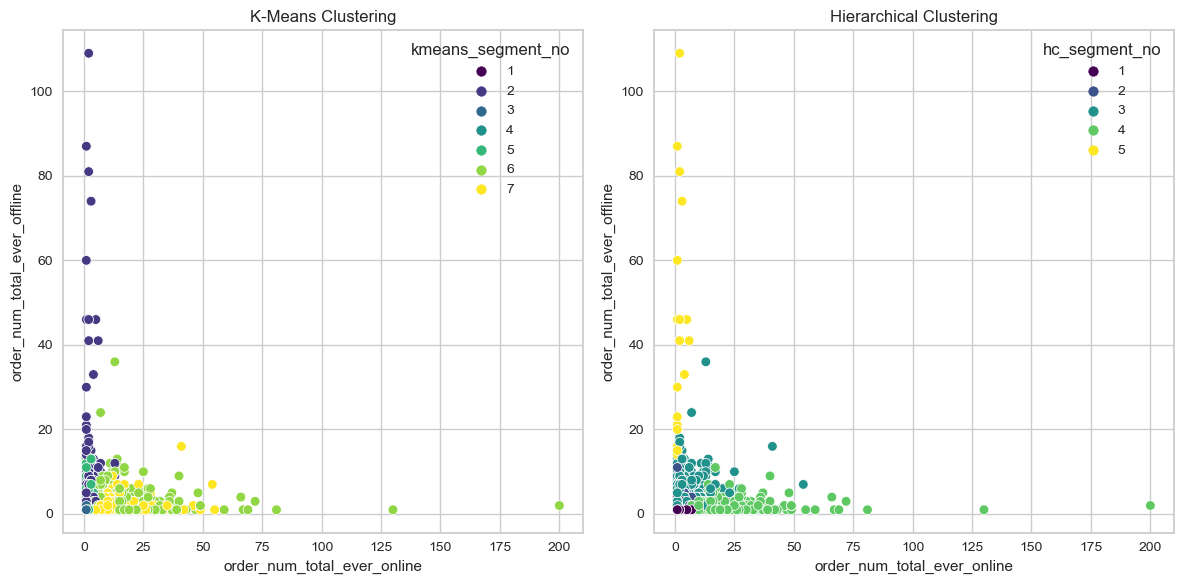

In [34]:
# Scatter plot for K-Means Clustering
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='order_num_total_ever_online', y='order_num_total_ever_offline', hue='kmeans_segment_no', data=df_final, palette='viridis', legend='full')
plt.title('K-Means Clustering')

# Scatter plot for Hierarchical Clustering
plt.subplot(1, 2, 2)
sns.scatterplot(x='order_num_total_ever_online', y='order_num_total_ever_offline', hue='hc_segment_no', data=df_final, palette='viridis', legend='full')
plt.title('Hierarchical Clustering')

plt.tight_layout()
plt.show()